## Solving BVPs by collocation

Sections 10.3, 10.4

Here we use the orthogonal polynomial approach used for function interpolation and integration to solve an ODE over an interval with high accuracy.

First we learn to write a matrix to compute the derivative of a function at a sequence of points.

In [1]:
using LinearAlgebra, DifferentialEquations, Plots

### Differentiation matrices

Split the interval $[a,b]$ into equally spaced pieces of length $h$, $x_i = a + ih$, $h = (b-a)/n$, $i = 0, \dots, n$.

Use two-point centred differences on the interior points, and two-point forward or backward differences at the end point. Do this for both the first and second derivatives.

The function to compute these matrices is straightforward.

In [2]:
"""
    diffmat2(n,xspan)

Compute 2nd-order-accurate differentiation matrices on `n`+1 points
in the interval `xspan`. Returns a vector of nodes and the matrices
for the first and second derivatives.
"""
function diffmat2(n,xspan)
    a,b = xspan
    h = (b-a)/n
    x = [ a + i*h for i in 0:n ]   # nodes

    # Define most of Dₓ by its diagonals.
    dp = fill(0.5/h,n)        # superdiagonal
    dm = fill(-0.5/h,n)       # subdiagonal
    Dₓ = diagm(-1=>dm,1=>dp)

    # Fix first and last rows.
    Dₓ[1,1:3] = [-1.5,2,-0.5]/h
    Dₓ[n+1,n-1:n+1] = [0.5,-2,1.5]/h

    # Define most of Dₓₓ by its diagonals.
    d0 =  fill(-2/h^2,n+1)    # main diagonal
    dp =  ones(n)/h^2         # super- and subdiagonal
    Dₓₓ = diagm(-1=>dp,0=>d0,1=>dp)

    # Fix first and last rows.
    Dₓₓ[1,1:4] = [2,-5,4,-1]/h^2
    Dₓₓ[n+1,n-2:n+1] = [-1,4,-5,2]/h^2

    return x,Dₓ,Dₓₓ
end

diffmat2

In [3]:
x, D1, D2 = diffmat2(4, (0,1))
D1

5×5 Matrix{Float64}:
 -6.0   8.0  -2.0   0.0  0.0
 -2.0   0.0   2.0   0.0  0.0
  0.0  -2.0   0.0   2.0  0.0
  0.0   0.0  -2.0   0.0  2.0
  0.0   0.0   2.0  -8.0  6.0

In [4]:
D2

5×5 Matrix{Float64}:
 32.0  -80.0   64.0  -16.0   0.0
 16.0  -32.0   16.0    0.0   0.0
  0.0   16.0  -32.0   16.0   0.0
  0.0    0.0   16.0  -32.0  16.0
  0.0  -16.0   64.0  -80.0  32.0

In [5]:
x

5-element Vector{Float64}:
 0.0
 0.25
 0.5
 0.75
 1.0

Use these matrices to compute a derivative over an interval.

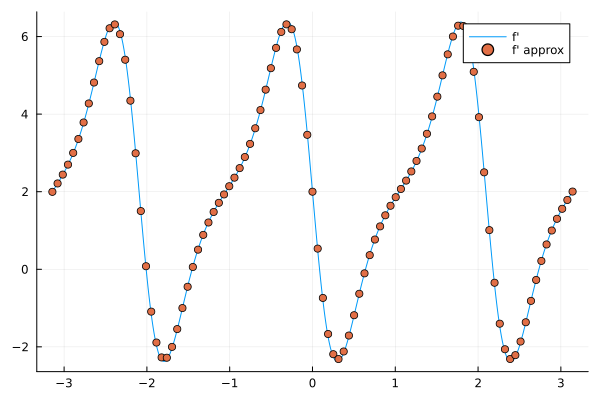

In [6]:
f(x) = 2*x + exp(cos(3*x))
df(x) = 2 - exp(cos(3*x))*sin(3*x)*3
using ForwardDiff
d2f = x -> ForwardDiff.derivative(df, x)
t_span = (-π, π)
t, D1, D2 = diffmat2(100, t_span)
plot(df, -pi, pi, label = "f'")
scatter!([t], D1 * f.(t), label = "f' approx")


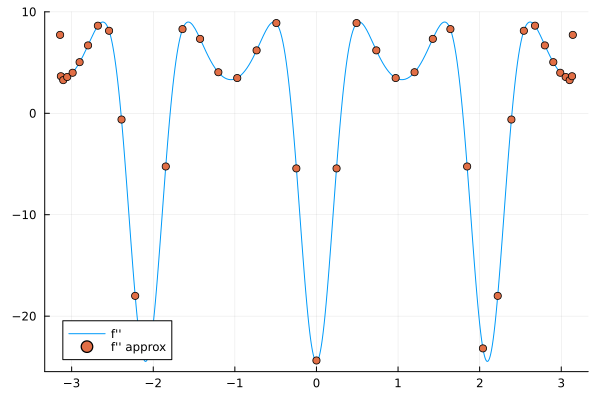

In [14]:
plot(d2f, -pi, pi, label = "f''")
scatter!([t], D2 * f.(t), label = "f'' approx")

Look at the error in the derivative as a function of the number of nodes used.

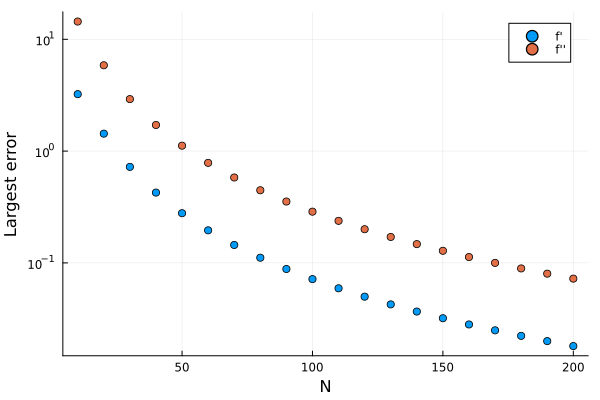

In [15]:
N = 20
e1 = zeros(N)
e2 = zeros(N)
for i in 1:N
    t, D1, D2 = diffmat2(10*i, t_span)
    e1[i] = norm( (D1 * f.(t)) .- df.(t), Inf)
    e2[i] = norm( (D2 * f.(t)) .- d2f.(t), Inf)
end
scatter(10 .* (1:N), e1, yscale = :log10, label = "f'")
scatter!(10 .* (1:N), e2, yscale = :log10, label = "f''", ylabel = "Largest error", xlabel = "N")

This is quadratic decrease in error. Change the x axis to a log scale to see a slope of -2 on these lines.

## Chebyshev differentiation matrix

Here we use the Chebyshev points $x_k = -\cos(k\pi/n)$. Then we interpolate the function at these nodes and differentiate the interpolant. See the textbook for details and exercises to work out omitted facts.

Compared to the previous differentiation matrix, which was mostly 0s, we see that there are no zeros here, because all nodes contribute to the derivative at every other node.

In [9]:
"""
    diffcheb(n,xspan)

Compute Chebyshev differentiation matrices on `n`+1 points in the
interval `xspan`. Returns a vector of nodes and the matrices for the
first and second derivatives.
"""
function diffcheb(n,xspan)
    x = [ -cos( k*π/n ) for k in 0:n ]    # nodes in [-1,1]
    
    # Off-diagonal entries.
    c = [2; ones(n-1); 2];    # endpoint factors
    dij = (i,j) -> (-1)^(i+j)*c[i+1]/(c[j+1]*(x[i+1]-x[j+1]))
    Dₓ = [ dij(i,j) for i in 0:n, j in 0:n ]

    # Diagonal entries.
    Dₓ[isinf.(Dₓ)] .= 0         # fix divisions by zero on diagonal
    s = sum(Dₓ,dims=2)
    Dₓ -= diagm(s[:,1])         # "negative sum trick"

    # Transplant to [a,b].
    a,b = xspan
    x = @. a + (b-a)*(x+1)/2
    Dₓ = 2*Dₓ/(b-a)             # chain rule

    # Second derivative.
    Dₓₓ = Dₓ^2
    return x,Dₓ,Dₓₓ
end

diffcheb

In [10]:
x, D1, D2 = diffcheb(10, (0, 1))
x

11-element Vector{Float64}:
 0.0
 0.024471741852423234
 0.09549150281252627
 0.20610737385376343
 0.3454915028125263
 0.49999999999999994
 0.6545084971874737
 0.7938926261462365
 0.9045084971874737
 0.9755282581475768
 1.0

In [11]:
D1

11×11 Matrix{Float64}:
 -67.0        81.7269   -20.9443   …   -2.21115    2.05017  -1.0
 -20.4317      9.95959   14.0806        1.13632   -1.05146   0.512543
   5.23607   -14.0806     2.34164      -1.23607    1.13632  -0.552786
  -2.42592     5.50553   -9.04029       1.43184   -1.29968   0.629808
   1.44721    -3.11507    4.0          -1.78885    1.58721  -0.763932
  -1.0         2.10292   -2.47214  …    2.47214   -2.10292   1.0
   0.763932   -1.58721    1.78885      -4.0        3.11507  -1.44721
  -0.629808    1.29968   -1.43184       9.04029   -5.50553   2.42592
   0.552786   -1.13632    1.23607      -2.34164   14.0806   -5.23607
  -0.512543    1.05146   -1.13632     -14.0806    -9.95959  20.4317
   1.0        -2.05017    2.21115  …   20.9443   -81.7269   67.0

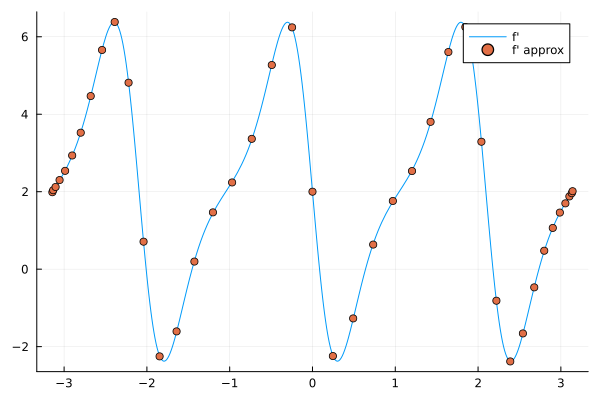

In [17]:
t, D1, D2 = diffcheb(40, t_span)
plot(df, -pi, pi, label = "f'")
scatter!([t], D1 * f.(t), label = "f' approx")

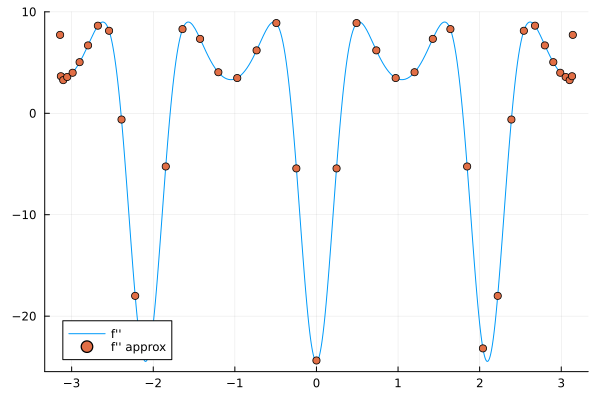

In [18]:
plot(d2f, -pi, pi, label = "f''")
scatter!([t], D2 * f.(t), label = "f'' approx")

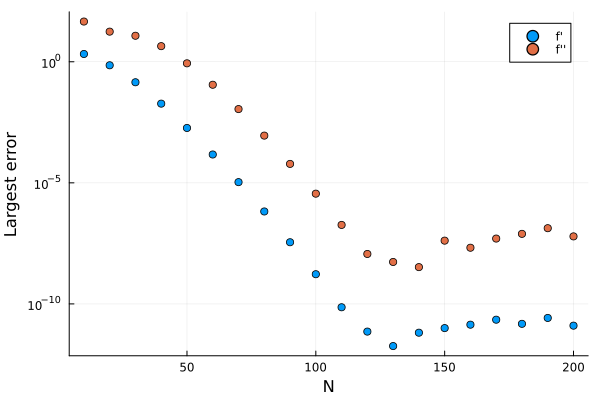

In [20]:
N = 20
e1 = zeros(N)
e2 = zeros(N)
for i in 1:N
    t, D1, D2 = diffcheb(10*i, t_span)
    e1[i] = norm( (D1 * f.(t)) .- df.(t), Inf)
    e2[i] = norm( (D2 * f.(t)) .- d2f.(t), Inf)
end
scatter(10 .* (1:N), e1, yscale = :log10, label = "f'")
scatter!(10 .* (1:N), e2, yscale = :log10, label = "f''", ylabel = "Largest error", xlabel = "N")

Notice how much faster the errors decrease compared to the second order differences with equally spaced points.

### Collocation solution to a linear BVP

Now we solve $u'' + p(x) u' + q(x) u = r(x)$, $u(a) = \alpha$, $u(b) = \beta$.

Two key features of this equation:

* it is linear in the derivatives $u''$, $u'$ and $u$.
* there is no $x$-dependence in $p$, $q$, or $r$.

We will use Chebyshev points $x_i$ to evaluate each of these functions. Then we can write the differential equation as a linear matrix equation $u'' + Pu' + Qu = r$ where $P$ and $Q$ are diagonal matrices with $P(x_i)$ and $Q(x_i)$ on the diagonals.

Writing $D_x$ and $D_{xx}$ for the derivative matrices, we write $u'' = D_{xx}u$ and $u' = D_xu$. The problem then can be written as a matrix equation $Lu = r$ with $L= D_{xx} + PD_x + Q$. This is a linear system of $n+1$ equations in $n+1$ unknowns.

To impose the boundary conditions, we delete the first and last equations (top and bottom rows of $L$) and replace them with two new equations imposing the boundary conditions.

Here's the textbook solution to this problem, changed to use chebyshev differentiation instead of two-point differences.

In [22]:
"""
    bvplin(p,q,r,xspan,lval,rval,n)

Use finite differences to solve a linear boundary value problem.
The ODE is u''+`p`(x)u'+`q`(x)u = `r`(x) on the interval `xspan`,
with endpoint function values given as `lval` and `rval`. There will
be `n`+1 equally spaced nodes, including the endpoints.

Returns vectors of the nodes and the solution values.
"""
function bvplin(p,q,r,xspan,lval,rval,n)
    x,Dₓ,Dₓₓ = diffcheb(n,xspan)

    P = diagm(p.(x))
    Q = diagm(q.(x))
    L = Dₓₓ + P*Dₓ + Q     # ODE expressed at the nodes

    # Replace first and last rows using boundary conditions.
    z = zeros(1,n)
    A = [ [1 z]; L[2:n,:]; [z 1] ]
    b = [ lval; r.(x[2:n]); rval ]

    # Solve the system.
    u = A\b
    return x,u
end

bvplin

We solve the following problem:

$$u'' -\cos(x) u' + \sin(x) u = 0, \ u(0) = 1, \ u(3\pi/2) = 1/e$$ 

In [24]:
p = x -> -cos(x)
q = x -> sin(x)
r = x -> 0
exact = x -> exp(sin(x))

#17 (generic function with 1 method)

In [25]:
x, u = bvplin(p, q, r, [0,3π/2], 1, exp(-1), 30);

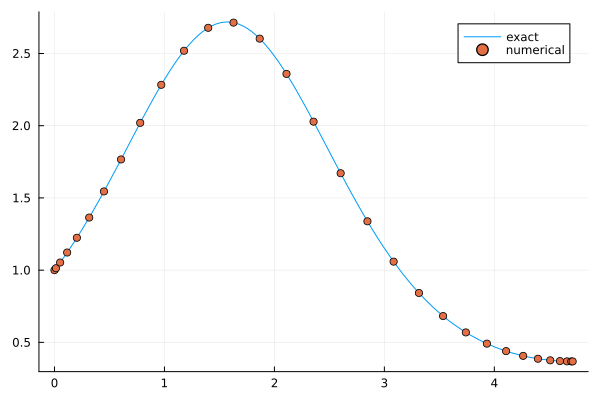

In [27]:
plot(exact, 0, 3*pi/2, label = "exact")
scatter!(x, u, label = "numerical")